# Setup

In [1]:
!pip install datatable==0.11.0 > /dev/null

In [2]:
import datatable as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [3]:
# Read data
pd_data = dt.fread('../input/train.csv').to_pandas()
pd_test = pd.read_csv('../input/example_test.csv')
#pd_feats = pd.read_csv('../input/features.csv')
#pd_pred = pd.read_csv('../input/example_sample_submission.csv')

# Train-Validation Split

In [18]:
i = int(pd_data.shape[0] * 0.05)
pd_train = pd_data.iloc[:-i, :]
pd_valid = pd_data.iloc[-i:, :]

print("n train: {}".format(pd_train.shape[0]))
print("n valid: {}".format(pd_valid.shape[0]))
print("n test:  {}".format(pd_test.shape[0]))

n train: 2270967
n valid: 119524
n test:  15219


# Preprocess

In [15]:
# Utilties
def filter_rows_with_zero_weight(pd_df):
    return pd_df.loc[pd_df.weight != 0]


def fill_missing_values(pd_df):
    return pd_df.fillna(-999)


def create_action_col(pd_df):
    return pd_df.assign(action=
        (((pd_df.weight * pd_df.resp) > 0).astype('int')))
                        

def convert_dtypes(pd_df):
    return pd_df.astype(
        {col: np.float32 for col in pd_df.select_dtypes(include='float64').columns})

In [22]:
# Preprocess data
pd_train = (pd_train
    .pipe(filter_rows_with_zero_weight)
    .pipe(fill_missing_values)
    .pipe(create_action_col)
    .pipe(convert_dtypes))

pd_valid = (pd_valid
    .pipe(filter_rows_with_zero_weight)
    .pipe(fill_missing_values)
    .pipe(create_action_col)
    .pipe(convert_dtypes))

pd_test = (pd_test
    .pipe(filter_rows_with_zero_weight)
    .pipe(fill_missing_values)
    .pipe(convert_dtypes))

In [26]:
# Save
pd_train.to_parquet("./data/clean/train.parquet")
pd_valid.to_parquet("./data/clean/valid.parquet")
pd_test.to_parquet("./data/clean/test.parquet")

In [ ]:
# Read
pd_train = pd.read_parquet("./data/clean/train.parquet")
pd_valid = pd.read_parquet("./data/clean/valid.parquet")
pd_test = pd.read_parquet("./data/clean/test.parquet")

In [27]:
# (Optional) Free memory
del pd_data

# EDA

In [35]:
display(pd_train.head())
pd_train.info()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,-999.0,-999.0,-0.151877,-0.384952,-999.0,-999.0,1.225838,0.789076,1.110580,1.102281,-999.0,-999.0,-0.590600,-0.625682,-999.0,-999.0,-0.543425,-0.547486,-0.706600,-0.667806,-999.0,-999.0,0.910558,0.914465,-999.0,-999.0,2.137454,2.080459,2.819291,2.483965,-0.086755,-0.082687,0.368431,0.469196,5.711996,-2.215132,0.796703,-1.140081,0.716617,-0.059431,-0.198920,-0.326697,-0.381770,1.435607,3.401393,2.486748,-2.014598,-0.390588,-999.0,-0.027262,-1.886927,-1.706450,-0.888236,-1.138294,-0.954461,-1.350633,-1.459546,-4.564815,-2.651966,-1.620014,-2.240625,-2.147273,-0.255224,3.202946,-0.535872,-999.0,-0.050948,-999.0,0.141089,0.058363,0.131190,-999.0,-0.121239,-999.0,0.677553,0.045842,-0.124616,-999.0,-0.007004,-999.0,-0.410491,-0.024323,-3.012654,-999.0,1.157670,-999.0,1.297679,1.281956,-2.427595,-999.0,0.024913,-999.0,-0.413607,-0.073672,-2.434546,-999.0,0.949879,-999.0,0.724655,1.622137,-2.209020,-999.0,-1.332492,-999.0,-0.586619,-1.040491,-3.946097,-999.0,0.983440,-999.0,1.357907,1.612348,-1.664544,-999.0,-999.0,-1.178850,1.777472,-0.915459,2.831612,-1.417010,2.297459,-1.304614,1.898684,1,0
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,-999.0,-999.0,2.683017,1.450991,-999.0,-999.0,1.257761,0.632336,0.905204,0.575275,-999.0,-999.0,2.550884,2.484082,-999.0,-999.0,2.502828,2.606440,2.731251,2.566561,-999.0,-999.0,-1.477905,-1.722451,-999.0,-999.0,-1.191981,-1.037629,-2.237275,-1.740456,0.326904,0.221809,-0.187586,-0.272907,0.870839,-1.256370,1.246881,-0.071239,2.085974,-0.864786,-1.794959,-1.706292,-1.503973,-0.903522,-1.493878,-0.916897,-2.874815,-2.452030,-999.0,0.545999,-1.572160,-1.265388,-0.402068,-1.185295,-0.986476,-1.794340,-1.995546,-4.252366,-1.793007,-1.181955,-2.116960,-2.030502,-2.810803,-3.467993,-2.050143,-999.0,0.410509,-999.0,0.252536,0.420685,0.170509,-999.0,1.621499,-999.0,1.697725,1.689662,0.016257,-999.0,0.464298,-999.0,-0.032422,0.187595,-2.788603,-999.0,4.345282,-999.0,2.737738,2.602937,-1.785502,-999.0,-0.172561,-999.0,-0.299516,-0.420021,-2.354611,-999.0,0.762192,-999.0,1.598620,0.623132,-1.742540,-999.0,-0.934675,-999.0,-0.373013,-1.213540,-3.677787,-999.0,2.684119,-999.0,2.861848,2.134804,-1.279284,-999.0,-999.0,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4,0
6,0,0.190575,-0.001939,-0.002301,0.001088,0.00

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880097 entries, 1 to 2270966
Columns: 139 entries, date to action
dtypes: float32(135), int32(3), int64(1)
memory usage: 1018.4 MB


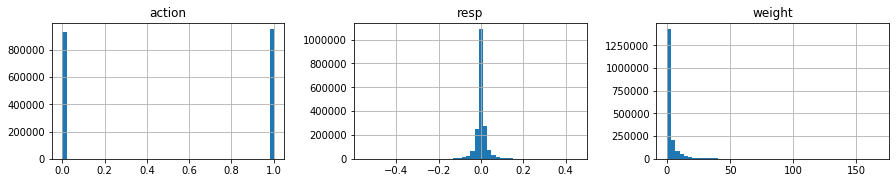

In [38]:
pd_train.hist(column=['weight', 'resp', 'action'], figsize=(15, 2.5), bins=50, layout=(1, 3))
plt.show()

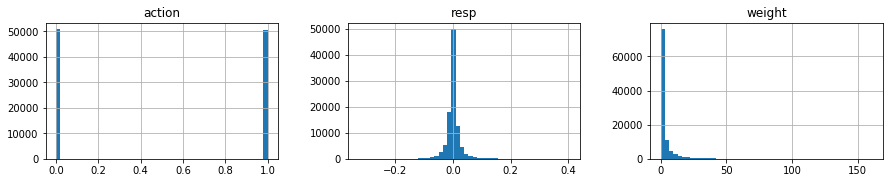

In [39]:
pd_valid.hist(column=['weight', 'resp', 'action'], figsize=(15, 2.5), bins=50, layout=(1, 3))
plt.show()

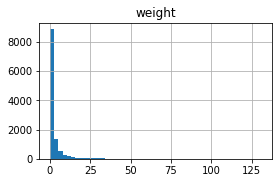

In [41]:
pd_test.hist(column=['weight'], figsize=(15, 2.5), bins=50, layout=(1, 3))
plt.show()